In [274]:
import wikipedia
import pandas as pd
from transformers import AutoTokenizer, TFAutoModelForMaskedLM
import tensorflow as tf
from datasets import Dataset
import datasets
from sklearn.cluster import DBSCAN
import numpy as np
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.express as px
from kneed import KneeLocator
from sklearn.metrics import silhouette_score

from sklearn.neighbors import NearestNeighbors


In [118]:
document = wikipedia.page("History of the United States").content

In [239]:
chunks = document.split('.')

In [240]:
df = pd.DataFrame(chunks, columns=['Chunks'])

In [241]:
display(df)

,Chunks
0,The history of the lands that became the Unite...
1,"Numerous indigenous cultures formed, and thei..."
2,"Starting in 1585, the British Empire colonize..."
3,\nThe Southern Colonies built an agricultural ...
4,"After defeating France, the British Parliamen..."
...,...
1312,National Endowment for the Humanities
1313,"Archived from the original on August 26, 2013"
1314,"\n""The Gilder Lehrman Institute of American Hi..."
1315,"\n""BackStory"""


In [242]:
dataset = Dataset.from_pandas(df)


In [243]:
dataset

Dataset({
    features: ['Chunks'],
    num_rows: 1317
})

In [244]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
model = TFAutoModelForMaskedLM.from_pretrained("google-bert/bert-base-uncased")

All PyTorch model weights were used when initializing TFBertForMaskedLM.

All the weights of TFBertForMaskedLM were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


In [245]:
text = df['Chunks'][0]
print(text)

The history of the lands that became the United States began with the arrival of the first people in the Americas around 15,000 BC


In [246]:
inputs = tokenizer(text, return_tensors='tf')
inputs

{'input_ids': <tf.Tensor: shape=(1, 28), dtype=int32, numpy=
array([[  101,  1996,  2381,  1997,  1996,  4915,  2008,  2150,  1996,
         2142,  2163,  2211,  2007,  1996,  5508,  1997,  1996,  2034,
         2111,  1999,  1996, 10925,  2105,  2321,  1010,  2199,  4647,
          102]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1, 28), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 28), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1]], dtype=int32)>}

In [247]:
outputs = model(inputs, output_hidden_states=True)
embeddings = outputs.hidden_states[-1][0]
embeddings.shape



TensorShape([28, 768])

In [248]:
tokens = inputs["input_ids"][0]
tokens.shape

TensorShape([28])

In [249]:
def embed(text):
    inputs = tokenizer(text, return_tensors='tf')
    outputs = model(inputs, output_hidden_states=True)
    tokens = inputs["input_ids"][0]
    embeddings = outputs.hidden_states[-1][0]
    print(tokens.shape, embeddings.shape)
    return {'embed':embeddings}



In [250]:
embeddings = embed(text)



(28,) (28, 768)


In [ ]:
embedded_dataset = dataset.map(lambda examples: embed(examples["Chunks"]))

In [ ]:
def average_embeddings(examples):
    examples['averaged_embeddings'] = [np.mean(embedding, axis=0) for embedding in examples['embed']]
    return examples

embedded_dataset = embedded_dataset.map(average_embeddings, batched=True)


In [145]:
embedded_dataset.save_to_disk("embedded_dataset")

Saving the dataset (0/1 shards):   0%|          | 0/1317 [00:00<?, ? examples/s]

In [251]:
embedded_dataset = datasets.load_from_disk("embedded_dataset")

In [252]:
embedded_dataset

Dataset({
    features: ['Chunks', 'embed', 'averaged_embeddings'],
    num_rows: 1317
})

In [148]:
embedded_dataset

Dataset({
    features: ['Chunks', 'embed', 'averaged_embeddings'],
    num_rows: 1317
})

In [149]:
averaged_embeddings = np.array(embedded_dataset['averaged_embeddings'])


In [150]:
averaged_embeddings[0]

array([ 2.91933189e-01,  2.38935067e-01, -2.95549260e-01, -3.09530402e-02,
        1.91675620e-01,  2.42365620e-01,  4.65356533e-01,  1.51655743e+00,
        2.04904145e-01, -5.26787011e-01,  6.22632124e-01, -2.46293679e-01,
       -6.23035505e-01,  7.76828167e-01, -4.15431642e-01, -5.13836176e-03,
        9.56747069e-02,  1.25752284e-01, -1.94744045e-01,  8.27311824e-01,
       -2.29377375e-01, -2.42147209e-01, -5.87919376e-02,  9.49582845e-01,
        1.01443603e+00, -4.32749240e-01, -1.09183687e-01, -1.00247050e-01,
        2.47775737e-03, -2.50279081e-01,  3.53006456e-01, -3.76418865e-01,
       -5.53884736e-01, -6.98244903e-01,  5.62679666e-02,  1.79717851e-01,
       -4.07017676e-01, -2.40618790e-01, -1.35182571e-01,  5.34231807e-01,
       -1.12296935e+00, -2.09376201e-01,  5.64076782e-01,  1.63721398e-01,
        1.14778718e-01,  3.50508316e-01,  5.37926793e-01,  5.93087370e-02,
       -1.52678554e-02, -2.28004138e-01, -1.89466496e-01, -2.03146572e-01,
       -4.41612639e-01,  

In [208]:
tsne = TSNE(n_components=2)
reduced_embeddings = tsne.fit_transform(averaged_embeddings)


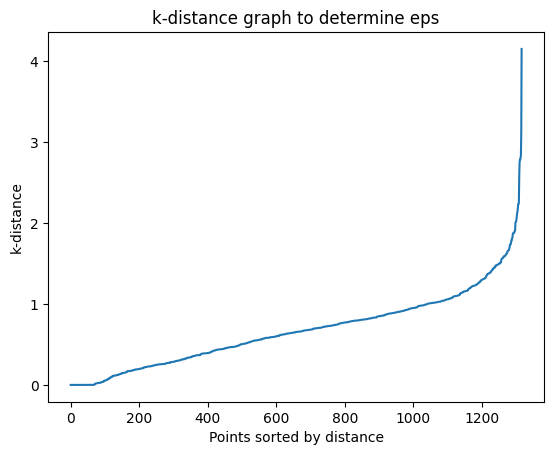

Optimal eps value: 1.8754749448624575


In [271]:
k = 2
neigh = NearestNeighbors(n_neighbors=k)
nbrs = neigh.fit(reduced_embeddings)
distances, indices = nbrs.kneighbors(reduced_embeddings)

distances = np.sort(distances[:, k-1], axis=0)
plt.plot(distances)
plt.xlabel('Points sorted by distance')
plt.ylabel('k-distance')
plt.title('k-distance graph to determine eps')
plt.show()

kneedle = KneeLocator(range(len(distances)), distances, S=1.0, curve='convex', direction='increasing')
optimal_eps = distances[kneedle.elbow]

print(f'Optimal eps value: {optimal_eps}')

In [277]:
min_samples_range = range(2, 50, 2)  # Adjust the range as needed
best_min_samples = 2
best_silhouette_score = -1
best_labels = None

for min_samples in min_samples_range:
    dbscan_model = DBSCAN(eps=optimal_eps, min_samples=min_samples, metric='cosine')
    labels = dbscan_model.fit_predict(reduced_embeddings)
    
    # Ignore noise points for silhouette score calculation
    if len(set(labels)) > 1 and len(set(labels)) < len(reduced_embeddings):
        score = silhouette_score(reduced_embeddings, labels)
        print(f'min_samples: {min_samples}, Silhouette Score: {score}')
        if score > best_silhouette_score:
            best_silhouette_score = score
            best_min_samples = min_samples
            best_labels = labels

print(f'Best min_samples value: {best_min_samples}, Best Silhouette Score: {best_silhouette_score}')

Best min_samples value: 2, Best Silhouette Score: -1


In [279]:
db = DBSCAN(eps=optimal_eps, min_samples=2).fit(reduced_embeddings)
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

clustered_dataset = embedded_dataset.add_column('cluster', labels)
clustered_dataset

Estimated number of clusters: 81
Estimated number of noise points: 22


Dataset({
    features: ['Chunks', 'embed', 'averaged_embeddings', 'cluster'],
    num_rows: 1317
})

In [298]:
tsne_df = pd.DataFrame(reduced_embeddings, columns=['Component 1', 'Component 2'])
tsne_df['text'] = clustered_dataset['Chunks']
tsne_df['cluster'] = clustered_dataset['cluster']


fig = px.scatter(
    tsne_df,
    x='Component 1',
    y='Component 2',
    color='cluster',
    hover_data=['text'],
    #color_continuous_scale=px.colors.diverging.BrBG
)

fig.show()

In [299]:
fig.write_html("interactive_plot.html")
